# Adaptive Learning and Design

## Estimation of Error Sources in QSPR/NN Prediction

Start by importing some modules, data from the paper, and writing some helper functions:

In [3]:
# libraries
import gains as genetic
from gains import adaptive as adl
import salty

import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.neighbors import KernelDensity
from sklearn.preprocessing import MinMaxScaler as mms

from rdkit.Chem import Draw
from rdkit import Chem
from rdkit.Chem.Draw import SimilarityMaps
from rdkit import DataStructs
import warnings
warnings.filterwarnings('ignore')

# paper data
df = pd.read_csv("../data/adaptive_learn_results.csv")

T = [297, 316] # select state variable ranges according to manuscript
P = [99, 102] # we will set MD simulation to 101 kPa and 298 K
data_range = [[206, 2295]] #the cpt dataset has one outlier ~9,000 J/mol/K
exp_data = ["cpt"]
cpt_data = salty.aggregate_data(exp_data,T=T,P=P,data_ranges=data_range)
exp_data = ["density"]
dens_data = salty.aggregate_data(exp_data,T=T,P=P)
overlap_data = salty.aggregate_data(['cpt', 'density'], T, P)
union_data = salty.aggregate_data(['cpt', 'density'], T, P, merge='Union')
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 8}

matplotlib.rc('font', **font)

# helper functions
def gaussian_pdf(column, h=0.01):
    x = column.values
    x_d = np.linspace(min(x), max(x), 10000)

    # instantiate and fit the KDE model
    kde = KernelDensity(bandwidth=h, kernel='gaussian')
    kde.fit(x[:, None])

    # score_samples returns the log of the probability density
    return kde.score_samples(x_d[:, None]), x_d

def kde2D(x, y, bandwidth, xbins=100j, ybins=100j, **kwargs): 
    """Build 2D kernel density estimate (KDE)."""

    # create grid of sample locations (default: 100x100)
    xx, yy = np.mgrid[0:x.max()+.1:xbins, 
                      y.min()-.1:y.max()+.1:ybins]

    xy_sample = np.vstack([yy.ravel(), xx.ravel()]).T
    xy_train  = np.vstack([y, x]).T
    
    #sklearn version
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(xy_train)

    # score_samples() returns the log-likelihood of the samples
    z = np.exp(kde_skl.score_samples(xy_sample))

    return xx, yy, np.reshape(z, xx.shape)

Let's first recreate the plots from Fig. 4 before diving into how the similarities and KDEs were computed: 

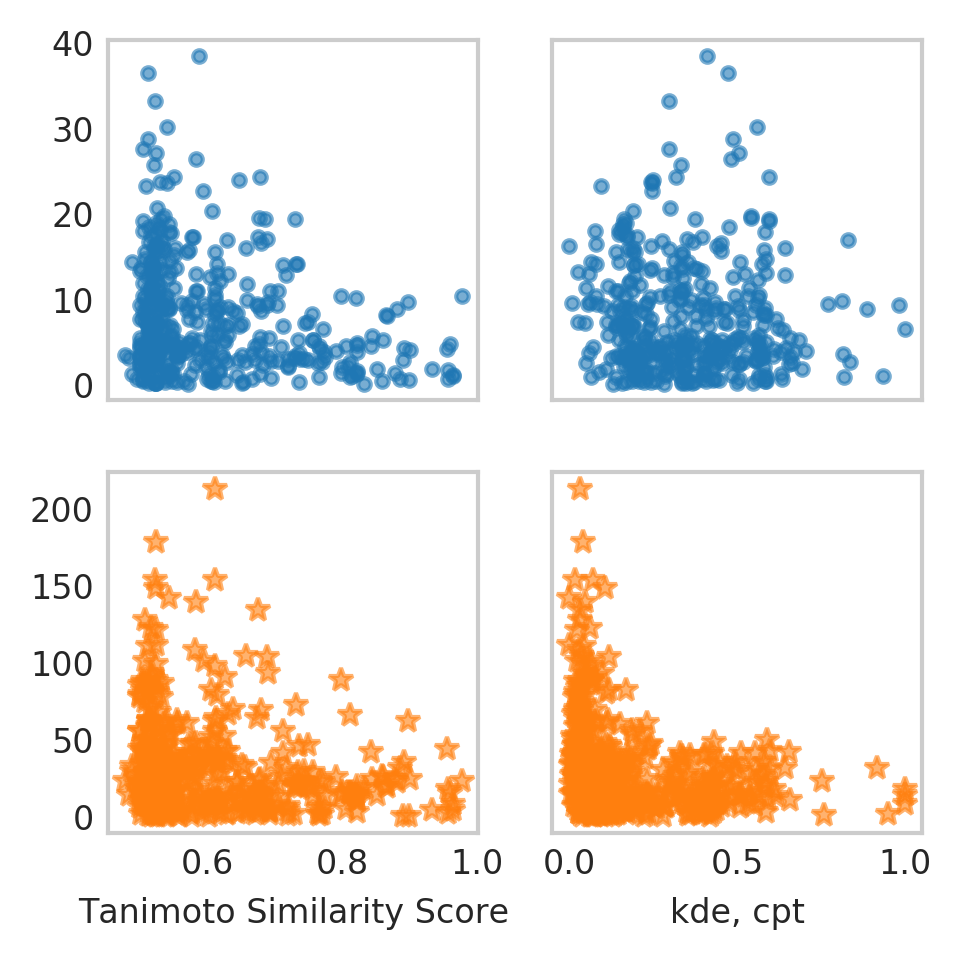

In [18]:
instance = mms(copy=False)
with plt.style.context('seaborn-whitegrid'):
    fig=plt.figure(figsize=(3.5,3.5), dpi=300)    
    ax1=fig.add_subplot(221)
    ax2=fig.add_subplot(222)   
    ax3=fig.add_subplot(223)
    ax4=fig.add_subplot(224)
    
    dff = df.loc[df['Tanimoto Similarity Score'] > 0.45] #outlier ~0.4
    dff.plot(ax=ax1, x='Tanimoto Similarity Score', y='% error, density',
            style='.', alpha=0.6, c='tab:blue', grid=False, sharey=True,
            sharex=True, legend=False)
    dff.plot(ax=ax3, x='Tanimoto Similarity Score', y='% error, cpt',
            style='*', alpha=0.6, c='tab:orange', grid=False, legend=False)
    
    df['kde, density'] = instance.fit_transform(df['kde, density'])
    df['kde, cpt'] = instance.fit_transform(df['kde, cpt'])
    dff.plot(ax=ax2, x='kde, density', y='% error, density',
            style='.', alpha=0.6, c='tab:blue', grid=False, sharey=True,
            sharex=True, legend=False)
    dff.plot(ax=ax4, x='kde, cpt', y='% error, cpt',
            style='*', alpha=0.6, c='tab:orange', grid=False, legend=False)

## Tanimoto Similarities

Load the example from Fig. 3 

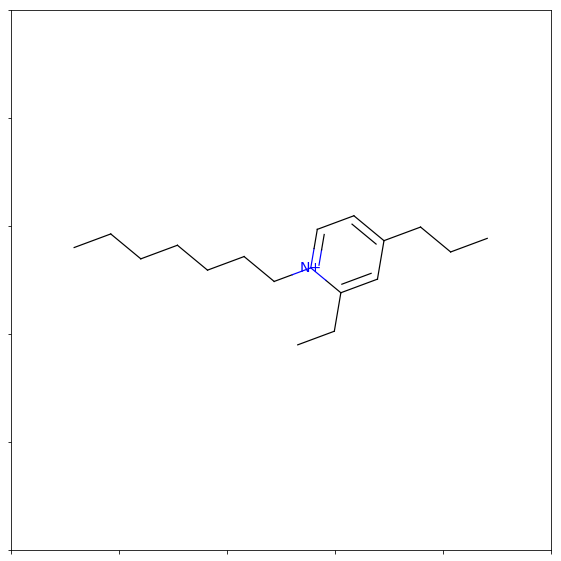

In [19]:
dff = df.loc[df['Salt Smiles'] == 'CCCCCCC[n+]1ccc(CCC)cc1CC.N#C[N-]C#N']
smi = dff.iloc[0]['Salt Smiles'].split(".")[0]
fig = Draw.MolToMPL(Chem.MolFromSmiles(smi))

In [5]:
parents = eval(union_data.Data_summary.iloc[1][0])
score, index = genetic.molecular_similarity(genetic.Chromosome(smi, 0), parents)
print("Tanimoto similarity with closest relative: {:.2f}".format(score))

Tanimoto similarity with closest relative: 0.78


Produce heatmap figure

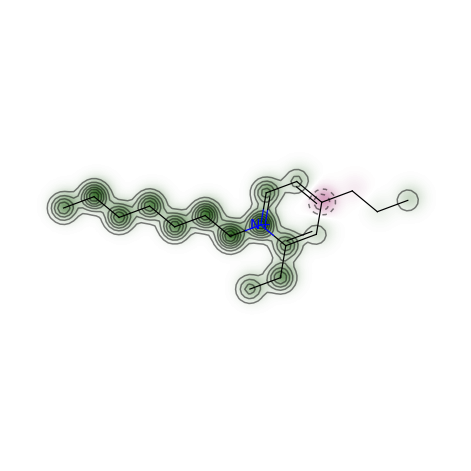

In [6]:
fig, maxweight = SimilarityMaps.GetSimilarityMapForFingerprint(Chem.MolFromSmiles(parents[index]),
                                             Chem.MolFromSmiles(smi),
                                             SimilarityMaps.GetMorganFingerprint,
                                             metric=DataStructs.TanimotoSimilarity)

Closest cation: 1-ethyl-2-hexylpyridin-1-ium


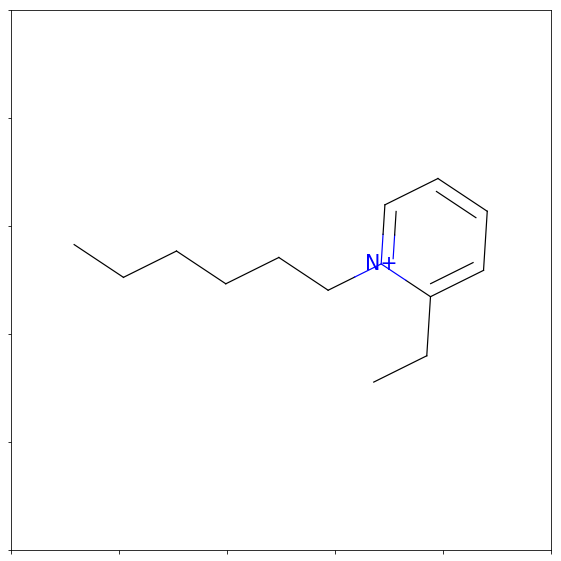

In [7]:
print("Closest cation: {}".format(salty.check_name(parents[index])))
fig = Draw.MolToMPL(Chem.MolFromSmiles(parents[index]))

## Kernel Density Estimates

In [8]:
#calc KDEs from experimental data
cpt_prob, cpt_x_d = gaussian_pdf(cpt_data.Data["Heat capacity at constant pressure, J/K/mol"])
dens_prob, dens_x_d = gaussian_pdf(dens_data.Data["Specific density, kg/m<SUP>3</SUP>"], h=0.003)

#calc averages
cpt_avg = np.exp(np.average(cpt_data.Data["Heat capacity at constant pressure, J/K/mol"]))
dens_avg = np.exp(np.average(dens_data.Data["Specific density, kg/m<SUP>3</SUP>"]))
print("average cpt and density: {:.1f} {:.1f}".format(cpt_avg, dens_avg))

#calc maximum KDEs
dens_key = np.argmax(abs(np.exp(dens_prob)))
max_dens_kde = np.exp(dens_x_d[dens_key])
print()
cpt_key = np.argmax(abs(np.exp(cpt_prob)))
max_cpt_kde = np.exp(cpt_x_d[cpt_key])
print("max cpt and density kde's: {:.1f} {:.1f}".format(max_cpt_kde, max_dens_kde))

average cpt and density: 471.8 1209.9

max cpt and density kde's: 416.3 1199.5


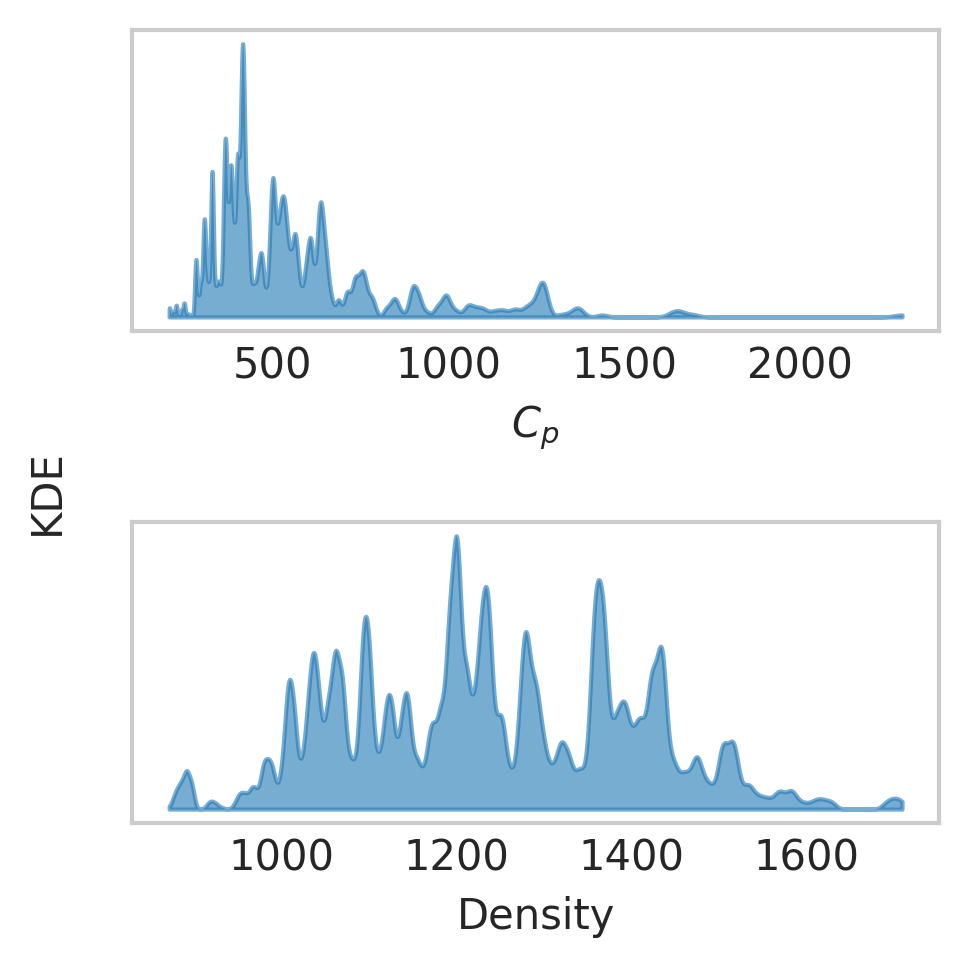

In [9]:
with plt.style.context('seaborn-whitegrid'):
    fig=plt.figure(figsize=(3,3), dpi=300)
    ax=fig.add_subplot(211)
    ax.fill_between(np.exp(cpt_x_d), np.exp(cpt_prob), color='tab:blue',
                          alpha=0.6)
    plt.xlabel('$C_p$')
    plt.tick_params(direction='in')
    plt.setp(ax.get_yticklabels(), visible=False)
    plt.grid()
    ax=fig.add_subplot(212)
    ax.yaxis.set_label_coords(-0.08,1.1)
    ax.fill_between(np.exp(dens_x_d), np.exp(dens_prob), color='tab:blue',
                          alpha=0.6)
    plt.xlabel('Density')
    plt.ylabel('KDE')
    plt.tick_params(direction='in')
    plt.setp(ax.get_yticklabels(), visible=False)
    plt.grid()
    plt.tight_layout(pad=0, w_pad=0, h_pad=0)

We can compute the KDE for the example from Fig. 3

In [10]:
instance = mms(copy=True)
dens_key = np.argmin(abs(np.exp(dens_x_d)-dff.iloc[0]['predicted density']))
dens_scaled = instance.fit_transform(np.exp(dens_prob))
dens_kde = dens_scaled[dens_key]

cpt_key = np.argmin(abs(np.exp(cpt_x_d)-dff.iloc[0]['predicted cpt']))
cpt_scaled = instance.fit_transform(np.exp(cpt_prob))
cpt_kde = cpt_scaled[cpt_key]

print("Density KDE: {:.3f}\t Cp KDE: {:.3f}".format(dens_kde, cpt_kde))

Density KDE: 0.116	 Cp KDE: 0.125


## Multivariate KDE

In [11]:
overlap_data.Data_summary

,0
Unique salts,98
Cations,"array(['CCCC[n+]1ccc(cc1)C', 'CCCCCCCCn1cc[n+]..."
Anions,"array(['[B-](F)(F)(F)F', 'F[P-](F)(F)(F)(F)F',..."
Total datapoints,4030
density,876.3 - 1551.8
cpt,207.47 - 1667.0
Temperature range (K),100.0 - 101.325
Pressure range (kPa),297.15 - 315.65


In [12]:
x = overlap_data.Data["Heat capacity at constant pressure, J/K/mol"]
y = overlap_data.Data["Specific density, kg/m<SUP>3</SUP>"]
xx, yy, zz = kde2D(x, y, 0.4)

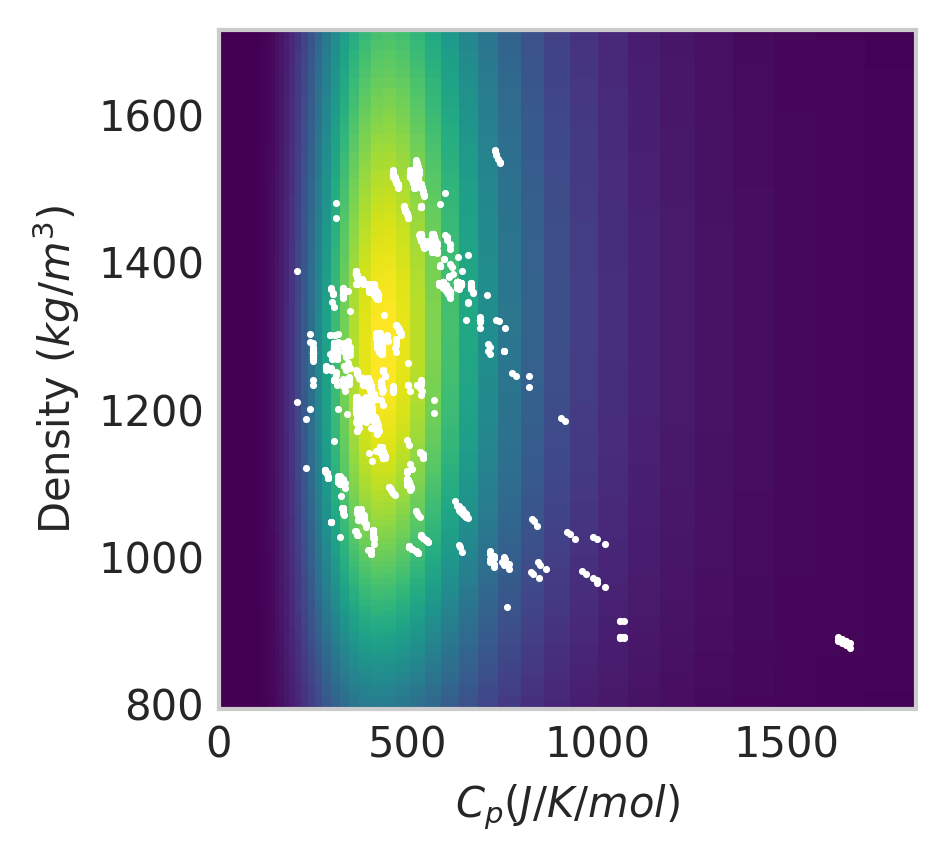

In [13]:
with plt.style.context('seaborn-whitegrid'):
    fig=plt.figure(figsize=(3,3), dpi=300)
    ax=fig.add_subplot(111)
    ax.pcolormesh(np.exp(xx), np.exp(yy), np.exp(zz), cmap='viridis')
    ax.scatter(np.exp(x), np.exp(y), s=.5, facecolor='white')
    plt.xlabel('$C_p (J/K/mol)$')
    plt.ylabel('Density $(kg/m^3)$')
    plt.tick_params(direction='in')